In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import time
from fpdf import FPDF

In [306]:
data = list()
filename = 'Cutoff_Data_201118_1140.txt'
with open(filename, 'r') as file:
    for line in file:
        data.append(line.strip("[]\n").split(','))
        
        
Number_of_Points = 50
labels = ['Time','V0_Write','CU_Pt','CU_V','BH_Pt','V0_Read','Emitted_Current','CU_Gun_Temp','Power_Read','BH_OC_Temp','CU_GUN_CHWR_Avg']
Data = pd.DataFrame(np.array(data).astype(float))
data = np.array(data).astype(float)
Data.columns = labels
offset = 70
Data['Sqrt_EC'] = Data.apply(lambda row: np.sqrt(row.Emitted_Current*1000 + offset), axis = 1)
Data['Time_Since_Start'] = Data.apply(lambda row: row.Time - Data.Time[0], axis = 1)
Data['EC_Mask'] = Data.Sqrt_EC.loc[(Data.V0_Write != Data.V0_Write[0]) & (Data.V0_Write != Data.V0_Write[Number_of_Points])]
BH_off_index = 0
for num, i in enumerate(Data.V0_Write):
    if i < Data.V0_Write[0]:
        BH_off_index = num
        break

if BH_off_index == 0:
    BH_off_index = len(Data.V0_Write)//2
    
Data['EC_Mask'] = Data.Sqrt_EC.loc[(Data.V0_Write != Data.V0_Write[0]) & (Data.V0_Write != Data.V0_Write[Number_of_Points]) \
                                   & (Data.V0_Write != Data.V0_Write[BH_off_index]) & (Data.V0_Write != Data.V0_Write[BH_off_index + Number_of_Points])]
print(Data.V0_Write[0], Data.V0_Write[Number_of_Points], Data.V0_Write[BH_off_index], Data.V0_Write[BH_off_index+Number_of_Points])
Data.head()

7.15 8.0 7.1 8.0


,Time,V0_Write,CU_Pt,CU_V,BH_Pt,V0_Read,Emitted_Current,CU_Gun_Temp,Power_Read,BH_OC_Temp,CU_GUN_CHWR_Avg,Sqrt_EC,Time_Since_Start,EC_Mask
0,1.605717e+09,7.150000,1.925229,110.096710,-7.516531,7.655758,-2.517731,51.210232,0.0,36.523560,2.043423,NaN,0.000000,NaN
1,1.605717e+09,7.167347,1.922050,109.975891,-7.510173,7.170521,0.005500,51.211323,0.0,36.525806,2.042771,8.689098,0.070058,8.689098
2,1.605717e+09,7.184694,1.928408,110.056419,-7.503815,7.172657,0.007942,51.212242,0.0,36.527863,2.042920,8.828470,0.145882,8.828470
3,1.605717e+09,7.202041,1.918871,109.935646,-7.503815,7.205007,0.006721,51.212761,0.0,36.529781,2.042284,8.759062,0.215700,8.759062
4,1.605717e+09,7.219388,1.925229,110.096710,-7.491099,7.205923,0.004280,51.213276,0.0,36.531723,2.041380,8.618570,0.285510,8.618570


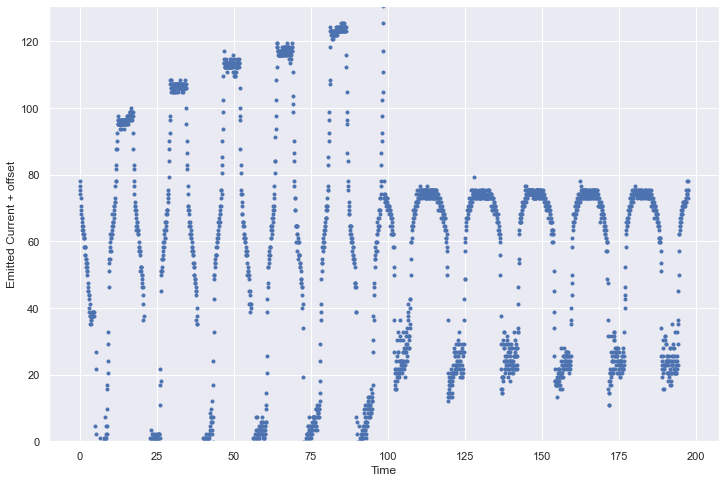

In [307]:
plt.figure(figsize = (12,8))
plt.scatter(Data.Time_Since_Start, \
          offset +  1000 * Data.Emitted_Current, label = 'Raw_Emitted_Current', marker = '.')
#plt.scatter(Data.Time_Since_Start,Data.CU_GUN_CHWR_Avg )
plt.ylim(0, max(offset +  1000 * Data.Emitted_Current))
plt.xlabel('Time')
plt.ylabel("Emitted Current + offset");

In [308]:
end_of_down_c1 = list()
end_of_up_c1 = list()
end_of_down_c2 = list()
end_of_up_c2 = list()
tf_swapper_1 = 0
tf_swapper_2 = 0
tf_swapper_3 = 0
tf_swapper_4 = 0
for num, i in enumerate(Data.V0_Write):
    if (i == Data.V0_Write[0]) & (num < BH_off_index):
        if tf_swapper_1 < 1:
            end_of_down_c1.append(num)
        tf_swapper_1 += 1
    else:
        if tf_swapper_1 > 1:
            end_of_down_c1.append(num-1)    
        tf_swapper_1 = 0
    if (i == Data.V0_Write[BH_off_index]) & (num > BH_off_index):
        if tf_swapper_2 < 1:
            end_of_down_c2.append(num)
        tf_swapper_2 += 1
    else:
        if tf_swapper_2 > 1:
            end_of_down_c2.append(num-1)  
        tf_swapper_2 = 0
    if (i == Data.V0_Write[Number_of_Points]) & (num < BH_off_index):
        if tf_swapper_3 < 1:
            end_of_up_c1.append(num)
        tf_swapper_3 += 1
    else:
        if tf_swapper_3 > 1:
            end_of_up_c1.append(num-1)  
        tf_swapper_3 = 0
    if (i == Data.V0_Write[BH_off_index + Number_of_Points]) & (num > BH_off_index):
        if tf_swapper_4 < 1:
            end_of_up_c2.append(num)
        tf_swapper_4 += 1
    else:
        if tf_swapper_4 > 1:
            end_of_up_c2.append(num-1)  
        tf_swapper_4 = 0
for i,j in zip(end_of_down_c1, end_of_up_c1):
    print(i,j)
end_of_down_c2.insert(0, end_of_down_c1[-1])
# end_of_up_c2.insert(0, end_of_up_c1[-1])

0 49
177 128
256 305
432 383
511 560
688 639
767 816
943 894
1021 1070
1198 1149
1276 1325
1453 1404


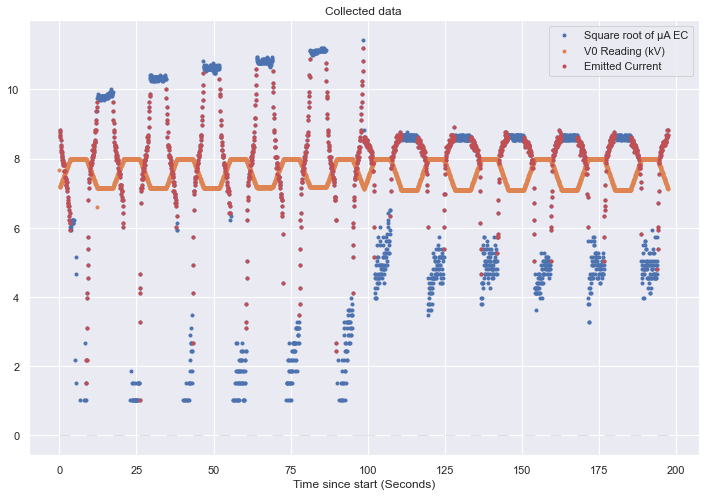

In [309]:
plt.figure(figsize = (12,8))
filter_1 = 0
filter_2 = -1
plt.scatter(Data.Time_Since_Start[filter_1:filter_2], Data.Sqrt_EC[filter_1:filter_2], label = 'Square root of \u03BCA EC', \
            marker = '.', color = sns.color_palette()[0])
plt.scatter(Data.Time_Since_Start[filter_1:filter_2], Data.V0_Read[filter_1:filter_2], label = 'V0 Reading (kV)', \
            marker = '.', color = sns.color_palette()[1])
plt.scatter(Data.Time_Since_Start[filter_1:filter_2], Data.EC_Mask[filter_1:filter_2], label = 'Emitted Current', \
            marker = '.', color = sns.color_palette()[3])
plt.xlabel('Time since start (Seconds)')
plt.title("Collected data")
thingy = 1
for index in [end_of_down_c1, end_of_down_c2, end_of_up_c1, end_of_up_c2]:
    plt.vlines(Data.Time_Since_Start[index], 0, max(Data.Sqrt_EC[filter_1:filter_2]))
#     if thingy % 2 == 0:
#         plt.subplots()[1].axvspan(Data.Time_Since_Start[index], Data.Time_Since_Start[index-1])#, alpha = 0.5, color = 'red')
#     thingy += 1
ROI_C2 = list()
ROI_C1 = list()
for down, up in zip(end_of_down_c1, end_of_up_c1):
    ROI_C1.append([down, up])
    plt.fill_betweenx([0,max(Data.Sqrt_EC[filter_1:filter_2])], \
                      Data.Time_Since_Start[down], Data.Time_Since_Start[up], \
                      color = 'gray', alpha = 0.25)
for down, up in zip(end_of_down_c2, end_of_up_c2):
    ROI_C2.append([down, up])
    plt.fill_betweenx([0,max(Data.Sqrt_EC[filter_1:filter_2])], \
                      Data.Time_Since_Start[up], Data.Time_Since_Start[down], \
                      color = 'gray', alpha = 0.25)
plt.legend()
plt.savefig('Figure_0.png', dpi = 120)
#plt.xlim(Data.Time_Since_Start[filter_1], Data.Time_Since_Start[filter_2])

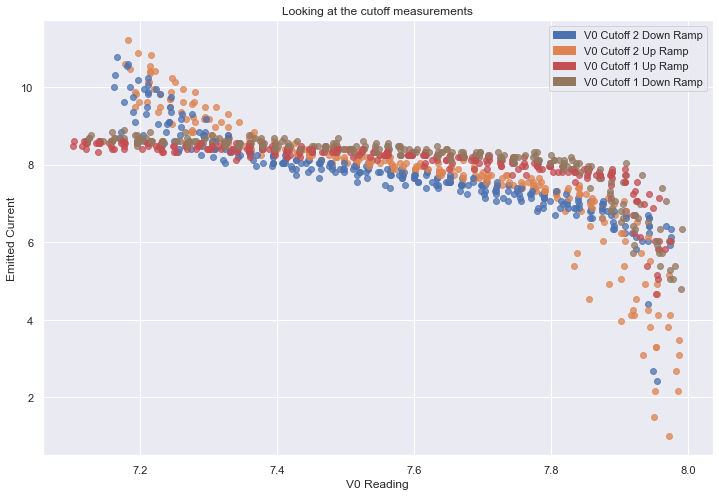

In [310]:
#plt.scatter(Data.V0_Read, Data.Emitted_Current)
BH_off_index = 0
for num, i in enumerate(Data.V0_Write):
    if i < Data.V0_Write[0]:
        BH_off_index = num
        break
        
plt.figure(figsize = (12,8))
for first, second in ROI_C1:
    if first > second:
        plt.scatter(Data.V0_Read[second:first], Data.EC_Mask[second:first], \
            alpha = 0.75, color = sns.color_palette()[1])
    plt.scatter(Data.V0_Read[first:second], Data.EC_Mask[first:second], \
            alpha = 0.75, color = sns.color_palette()[0])
for first, second in ROI_C2:
    if first > second:
        plt.scatter(Data.V0_Read[second:first], Data.EC_Mask[second:first], \
            alpha = 0.75, color = sns.color_palette()[5])
    plt.scatter(Data.V0_Read[first:second], Data.EC_Mask[first:second], \
            alpha = 0.75, color = sns.color_palette()[3])
plt.xlabel('V0 Reading')
plt.ylabel('Emitted Current')
plt.title("Looking at the cutoff measurements")

palette = dict(zip(['one', 'two', 'three', 'four'], \
                   [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[3], sns.color_palette()[5]]))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]

plt.legend(handles = handles, labels = \
           ["V0 Cutoff 2 Down Ramp", 'V0 Cutoff 2 Up Ramp', 'V0 Cutoff 1 Up Ramp', 'V0 Cutoff 1 Down Ramp'])

plt.savefig("Figure_1.png", dpi = 120)

Implied cutoff: 10.29kV
Implied cutoff: 8.95kV
Implied cutoff: 10.44kV
Implied cutoff: 9.86kV
Implied cutoff: 10.17kV
Implied cutoff: 10.20kV
Implied cutoff: 10.19kV
Implied cutoff: 9.54kV
Implied cutoff: 9.78kV
Implied cutoff: 9.46kV
Implied cutoff: 9.78kV
Implied cutoff: 9.63kV
Average R² of 0.8802


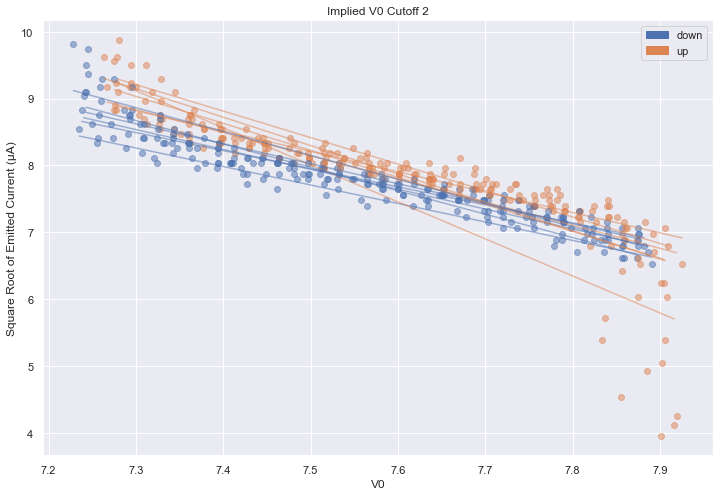

In [311]:
model = LinearRegression()

intercepts = list()
coefficients = list()
implied_cutoffs = list()
scores = []

i = 0

plt.figure(figsize = (12,8))
plt.title('Implied V0 Cutoff 2')
plt.xlabel('V0')
plt.ylabel('Square Root of Emitted Current (\u03BCA)')

offset_value = 5

for first, second in ROI_C1:
    i += 1
    color = sns.color_palette()[0] 
    if i % 2 == 0:
#         continue
        color = sns.color_palette()[1]
        pass
    
    if second < first:
        first, second = second, first
        
    model = LinearRegression()
    mask = [not x for x in np.isnan(Data.EC_Mask[first + offset_value:second - offset_value])]
    x = np.array(Data.V0_Read[first + offset_value:second - offset_value][mask]).reshape(-1,1)
    y = np.array(Data.EC_Mask[first + offset_value:second - offset_value][mask]).reshape(-1,1)
#     print(x.shape, y.shape)
    model.fit(x,y)
    scores.append(model.score(x,y))
    m, b = float(model.coef_), float(model.intercept_)
    coefficients.append(m)
    intercepts.append(b)
    implied_cutoffs.append(-b/m)
    print("Implied cutoff: {:.2f}kV".format(-b/m))
    xnums = np.linspace(min(x), max(x), 50)
    ynums = m*xnums + b
    plt.plot(xnums, ynums, color = color, alpha = 0.5)
    plt.scatter(Data.V0_Read[first + offset_value:second - offset_value],\
                Data.EC_Mask[first + offset_value:second - offset_value], \
                color = color, alpha = 0.5)
    

palette = dict(zip(['one', 'two'], [sns.color_palette()[0], sns.color_palette()[1]]))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]

plt.legend(handles = handles, labels = ["down", 'up'])
    
BH_Off_Time = Data.Time_Since_Start[second]
#print(BH_Off_Time)
print('Average R\u00b2 of {:.4f}'.format(sum(scores)/len(scores)))
Average_V0_Cutoff_2_Score = sum(scores)/len(scores)
plt.savefig("Figure_2.png", dpi = 120)

Implied cutoff: 15.48kV; R²: 0.7943
Implied cutoff: 15.88kV; R²: 0.7962
Implied cutoff: 16.11kV; R²: 0.7858
Implied cutoff: 14.54kV; R²: 0.7928
Implied cutoff: 16.13kV; R²: 0.8194
Implied cutoff: 12.71kV; R²: 0.6473
Implied cutoff: 16.06kV; R²: 0.7725
Implied cutoff: 12.85kV; R²: 0.6289
Implied cutoff: 14.95kV; R²: 0.7597
Implied cutoff: 12.81kV; R²: 0.6526
Implied cutoff: 15.27kV; R²: 0.8115
Implied cutoff: 13.99kV; R²: 0.6776


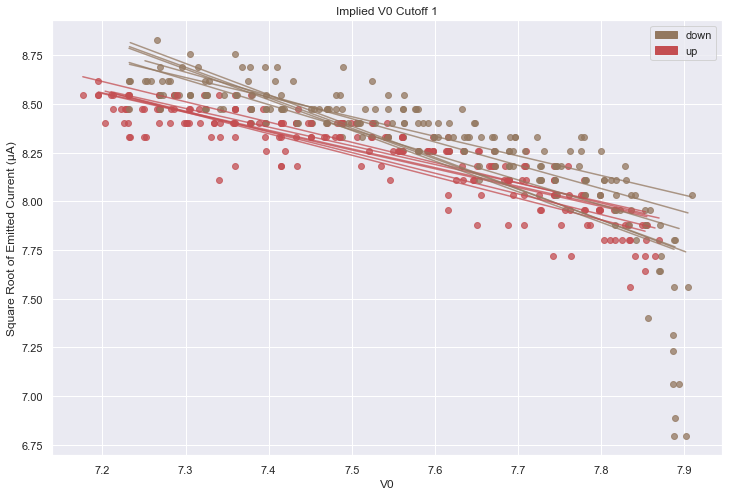

In [316]:
intercepts_2 = list()
coefficients_2 = list()
implied_cutoffs_2 = list()
times = list()
scores = list()

plt.figure(figsize = (12,8))
plt.title('Implied V0 Cutoff 1')
plt.xlabel('V0')
plt.ylabel('Square Root of Emitted Current (\u03BCA)')

offset_value = 6
for first, second in ROI_C2:
    color = sns.color_palette()[3]
    if second < first:
        first, second = second, first
        times.append(Data.Time_Since_Start[second] - BH_Off_Time)
        color = sns.color_palette()[5]
    else:
        times.append(Data.Time_Since_Start[first] - BH_Off_Time)
        
    model = LinearRegression()
    mask = [not x for x in np.isnan(Data.EC_Mask[first + offset_value:second - offset_value])]
    x = np.array(Data.V0_Read[first + offset_value:second - offset_value][mask]).reshape(-1,1)
    y = np.array(Data.EC_Mask[first + offset_value:second - offset_value][mask]).reshape(-1,1)
#     print(x.shape, y.shape)
    model.fit(x,y)
    score = model.score(x,y)
    scores.append(score)
    m, b = float(model.coef_), float(model.intercept_)
    coefficients_2.append(m)
    intercepts_2.append(b)
    implied_cutoffs_2.append(-b/m)
    print("Implied cutoff: {:.2f}kV; R\u00b2: {:.4f}".format(-b/m, score))
    xnums = np.linspace(min(x), max(x), 50)
    ynums = m*xnums + b
    plt.plot(xnums, ynums, color = color, alpha = 0.75)
    plt.scatter(Data.V0_Read[first + offset_value:second - offset_value],\
                Data.EC_Mask[first + offset_value:second - offset_value], \
                color = color, alpha = 0.75)
palette = dict(zip(['one', 'two'], [sns.color_palette()[5], sns.color_palette()[3]]))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]

plt.legend(handles = handles, labels = ["down", 'up'])
#print(times)
plt.savefig('Figure_3.png', dpi = 120)

Implied V0 Cutoff 1 from down ramp at t=0 is 13.05 kV
Implied V0 Cutoff 1 from up ramp at t=0 is 12.19 kV


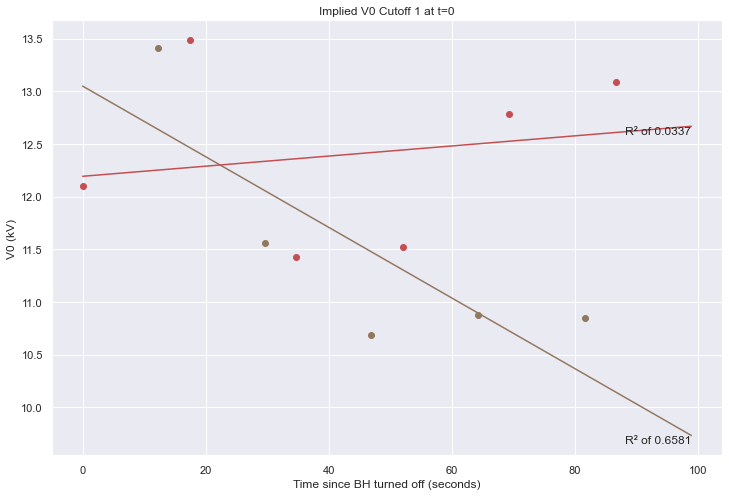

In [313]:
plt.figure(figsize = (12,8))
plt.title('Implied V0 Cutoff 1 at t=0')
plt.xlabel('Time since BH turned off (seconds)')
plt.ylabel('V0 (kV)')


model = LinearRegression()
model_2 = LinearRegression()
# times.pop()
# implied_cutoffs_2.pop()
Up = True
Down = True

if Up:
    times_mask = times[1::2]
    implied_cutoffs_2_mask = implied_cutoffs_2[1::2]
    times_mask.pop()
    implied_cutoffs_2_mask.pop()
    
if Down:
    times_mask_2 = times[::2]
    implied_cutoffs_2_mask_2 = implied_cutoffs_2[::2]

plt.scatter(times_mask, implied_cutoffs_2_mask, color = sns.color_palette()[5])
model.fit(np.array(times_mask).reshape(-1,1), implied_cutoffs_2_mask)
m,b = model.coef_, model.intercept_
model_score = model.score(np.array(times_mask).reshape(-1,1), implied_cutoffs_2_mask)
xnums = np.linspace(0,max(times), 100)
ynums = m*xnums + b
plt.plot(xnums, ynums, color = sns.color_palette()[5])
plt.annotate(text = "R\u00b2 of {:.4f}".format(model_score), xy= [xnums[-1],ynums[-1]], ha = 'right', va = 'top')
print("Implied V0 Cutoff 1 from down ramp at t=0 is {:.2f} kV".format(b))
plt.scatter(times_mask_2, implied_cutoffs_2_mask_2, color = sns.color_palette()[3])
model_2.fit(np.array(times_mask_2).reshape(-1,1), implied_cutoffs_2_mask_2)
m_2,b_2 = model_2.coef_, model_2.intercept_
model_2_score = model_2.score(np.array(times_mask_2).reshape(-1,1), implied_cutoffs_2_mask_2)
xnums_2 = np.linspace(0,max(times), 100)
ynums_2 = m_2*xnums_2 + b_2
plt.plot(xnums_2, ynums_2, color = sns.color_palette()[3])
plt.annotate(text = "R\u00b2 of {:.4f}".format(model_2_score), xy= [xnums_2[-1],ynums_2[-1]], ha = 'right', va = 'top')
print("Implied V0 Cutoff 1 from up ramp at t=0 is {:.2f} kV".format(b_2))
implied_c1_down = b
implied_c1_up = b_2
plt.savefig("Figure_4.png", dpi = 120)

In [314]:
print("Implied cutoff 2 from average down ramp is {:.2f}kV".format(sum(implied_cutoffs[1::2])/len(implied_cutoffs[1::2])))
implied_c2_down = sum(implied_cutoffs[1::2])/len(implied_cutoffs[1::2])
print("Implied cutoff 2 from average up ramp is {:.2f}kV".format(sum(implied_cutoffs[::2])/len(implied_cutoffs[::2])))
implied_c2_up = sum(implied_cutoffs[::2])/len(implied_cutoffs[::2])

Implied cutoff 2 from average down ramp is 9.60kV
Implied cutoff 2 from average up ramp is 10.11kV


In [317]:
Implied_V2 = abs(implied_c2_up-implied_c1_up)
print("Implied V2 from down ramp of both cutoff measurements is {:.2f}kV".format(Implied_V2))

Implied V2 from down ramp of both cutoff measurements is 2.08kV


In [281]:
start_time = time.time()
pdf = FPDF()
pdf.add_page()
pdf.set_xy(5, 5)
pdf.set_font('arial', 'B', 8)
pdf.cell(60)
pdf.cell(75, 10, "Automated Cutoff Data taken {} Report".format(201010), 0, 2, "C")
#pdf.cell(90, 10, " ", 0, 2, 'L')
pdf.cell(-40)
pdf.cell(75,10, "Implied V0 cutoff 1 at time t=0 for down ramp: {:.2f}kV".format(implied_c1_down), 0, 2, 'L')
pdf.cell(75,10, "Implied V0 cutoff 1 at time t=0 for up ramp: {:.2f}kV".format(implied_c1_up), 0, 2, 'L')
pdf.cell(75,10, "Implied V0 cutoff 2 for down ramp: {:.2f}kV".format(implied_c2_down), 0, 2, 'L')
pdf.cell(75,10, "Implied V0 cutoff 2 for up ramp: {:.2f}kV".format(implied_c2_up), 0, 2, 'L')
pdf.cell(75,10, "How we got these results", 0, 2, 'L')
pdf.cell(75,10, "Here is the data that we're working with", 0, 2, 'L')
pdf.image('Figure_0.png', x = None, y = None, w = 180, h = 0, type = '', link = '')
pdf.add_page()
pdf.set_font('arial', 'B', 8)
pdf.cell(15)
pdf.cell(75,10, "Looking at our cutoff 1 and 2", 0, 2, 'L')
pdf.image('Figure_1.png', x = None, y = None, w = 180, h = 0, type = '', link = '')
pdf.add_page()
pdf.set_font('arial', 'B', 8)
pdf.cell(15)
for num, value in enumerate(implied_cutoffs):
    if num % 2 == 0:
        pdf.cell(75,10, "Implied V0 Cutoff on up swing of V0: {:.2f}kV with a confidence of {:.4f}".format(value, scores[num]), \
                 0, 2, 'L')
    else:
        pdf.cell(75,10, "Implied V0 Cutoff on down swing of V0: {:.2f}kV with a confidence of {:.4f}".format(value, scores[num]), \
                 0, 2, 'L')
pdf.image('Figure_2.png', x = None, y = None, w = 180, h = 0, type = '', link = '')
pdf.add_page()
pdf.set_font('arial', 'B', 8)
pdf.cell(15)
for num, value in enumerate(implied_cutoffs_2):
    if num % 2 == 0:
        pdf.cell(75,10, "Implied V0 Cutoff on up swing of V0: {:.2f}kV with a confidence of {:.4f}".format(value, scores[num]), \
                 0, 2, 'L')
    else:
        pdf.cell(75,10, "Implied V0 Cutoff on down swing of V0: {:.2f}kV with a confidence of {:.4f}".format(value, scores[num]), \
                 0, 2, 'L')
pdf.image('Figure_3.png', x = None, y = None, w = 180, h = 0, type = '', link = '')
pdf.add_page()
pdf.set_font('arial', 'B', 8)
pdf.cell(15)
pdf.cell(75,10, "Extrapolating back to moment when BH was turned off", 0, 2, 'L')
pdf.cell(75,10, "Implied V0 cutoff 1 at time t=0 for down ramp: {:.2f}kV".format(implied_c1_down), 0, 2, 'L')
pdf.cell(75,10, "Implied V0 cutoff 1 at time t=0 for up ramp: {:.2f}kV".format(implied_c1_up), 0, 2, 'L')
pdf.image('Figure_4.png', x = None, y = None, w = 180, h = 0, type = '', link = '')

pdf.output(filename[:-4] + '_report.pdf', 'F')
print(time.time() - start_time)

20.723297119140625
